# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/Amazon_Historical_StockPrice2.csv')

In [2]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1677.254199,1694.635633,1657.249580,1676.504673,1676.504673,4.318210e+06
std,787.593224,798.250932,774.769809,786.149289,786.149289,2.089566e+06
min,580.150024,584.750000,575.559998,579.869995,579.869995,8.813000e+05
25%,967.990005,974.467499,959.544983,966.027512,966.027512,2.908675e+06
50%,1676.494995,1698.104980,1654.445007,1671.174988,1671.174988,3.716250e+06
75%,1932.977478,1951.877502,1908.004974,1928.965027,1928.965027,5.122475e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.656500e+07


In [3]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400
5,2016-04-04,599.000000,599.500000,590.549988,593.190002,593.190002,2470800
6,2016-04-05,590.770020,593.469971,585.250000,586.140015,586.140015,2308900
7,2016-04-06,587.520020,602.390015,587.500000,602.080017,602.080017,2849900
8,2016-04-07,598.760010,599.599976,589.080017,591.429993,591.429993,3189000
9,2016-04-08,594.320007,597.859985,589.000000,594.599976,594.599976,2591900


In [4]:
df.shape

(1260, 7)

Давайте сгруппируем цену акций по неделям, рассматривая среднюю цену.

In [5]:
df['Avg'] = (df['High'] + df['Low']) / 2

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Week'] = df['Date'].map(lambda date : str(date.isocalendar()[0]) + '-' + str(date.isocalendar()[1]))

df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Avg,Week
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500,580.154999,2016-13
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600,586.174988,2016-13
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500,599.119995,2016-13
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800,596.480011,2016-13
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400,593.665009,2016-13
5,2016-04-04,599.000000,599.500000,590.549988,593.190002,593.190002,2470800,595.024994,2016-14
6,2016-04-05,590.770020,593.469971,585.250000,586.140015,586.140015,2308900,589.359985,2016-14
7,2016-04-06,587.520020,602.390015,587.500000,602.080017,602.080017,2849900,594.945007,2016-14
8,2016-04-07,598.760010,599.599976,589.080017,591.429993,591.429993,3189000,594.339996,2016-14
9,2016-04-08,594.320007,597.859985,589.000000,594.599976,594.599976,2591900,593.429993,2016-14


Как можно видеть, по некоторым дням (выходным) биржа не работает. Кроме того, в некоторые праздники она тоже закрывается, поэтому нам нужно вытащить из даты год и неделю.

In [6]:
dfw = df.groupby(['Week']).mean()

dfw.head()

,Open,High,Low,Close,Adj Close,Volume,Avg
Week,,,,,,,
2016-13,590.206018,596.723999,585.514001,592.912000,592.912000,3400760.0,591.119000
2016-14,594.074011,598.563989,588.276001,593.488000,593.488000,2682100.0,593.419995
2016-15,607.842004,615.204004,605.137988,612.112000,612.112000,3194700.0,610.170996
2016-16,629.591992,635.654004,621.764001,629.547998,629.547998,3741280.0,628.709003
2016-17,627.223987,633.291992,617.122009,622.248010,622.248010,5491280.0,625.207001


In [7]:
dfw.describe()

,Open,High,Low,Close,Adj Close,Volume,Avg
count,261.000000,261.000000,261.000000,261.000000,261.000000,2.610000e+02,261.000000
mean,1677.688619,1695.127249,1657.763004,1677.039826,1677.039826,4.312686e+06,1676.445127
std,787.418614,798.273737,774.782569,786.166225,786.166225,1.660195e+06,786.471431
min,590.206018,596.723999,585.514001,592.912000,592.912000,1.809940e+06,591.119000
25%,974.205002,976.629993,962.133997,969.610001,969.610001,3.143200e+06,969.737994
50%,1671.059985,1688.945996,1653.216016,1672.993994,1672.993994,3.800020e+06,1671.081006
75%,1927.285986,1953.093994,1910.100000,1929.357959,1929.357959,5.168640e+06,1929.109998
max,3449.714014,3486.206006,3354.563965,3428.830029,3428.830029,1.048892e+07,3420.384985


<AxesSubplot:title={'center':'No grouping'}, xlabel='Date', ylabel='Price'>

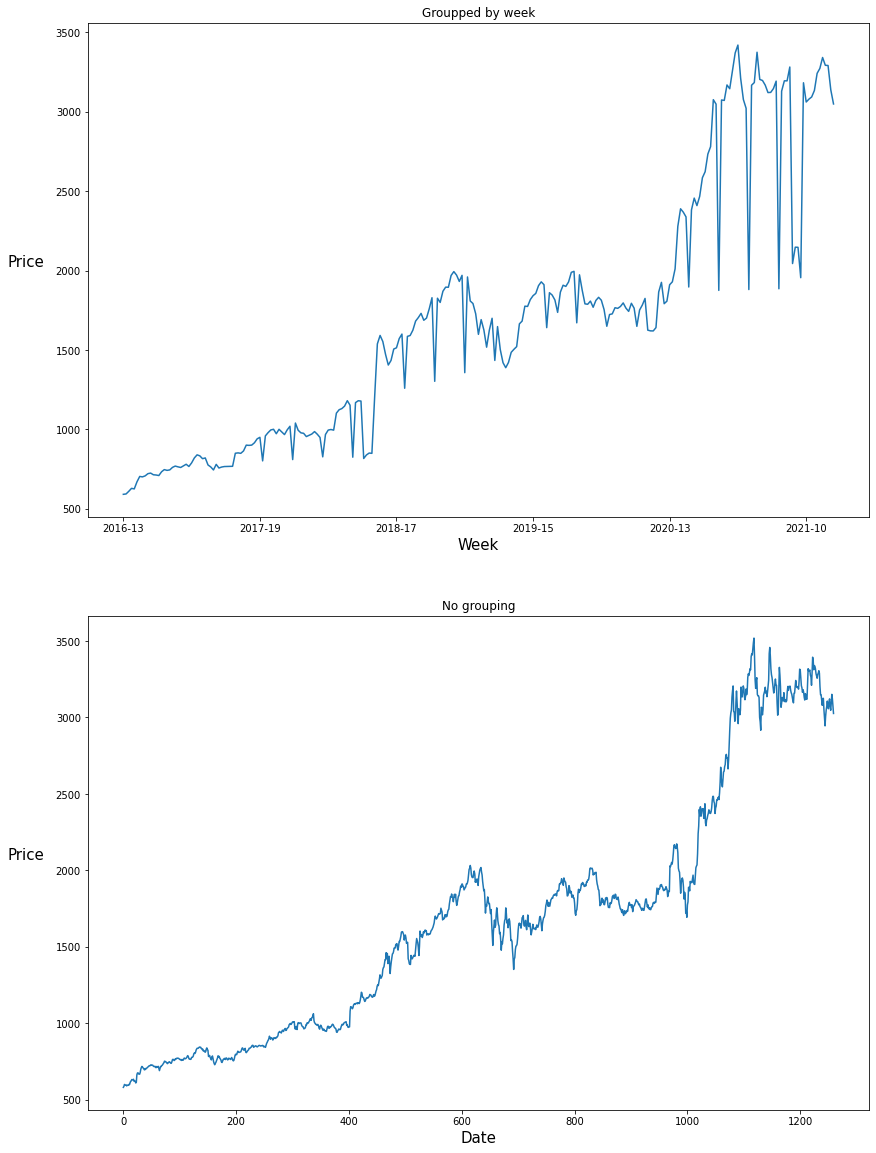

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))

ax[0].set_title('Groupped by week')
ax[0].set_xlabel('Date', fontsize=15)
ax[0].set_ylabel('Price', rotation=0, labelpad=30, fontsize=15)
dfw['Avg'].plot(ax=ax[0])

ax[1].set_title('No grouping')
ax[1].set_xlabel('Date', fontsize=15)
ax[1].set_ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['Avg'].plot(ax=ax[1])

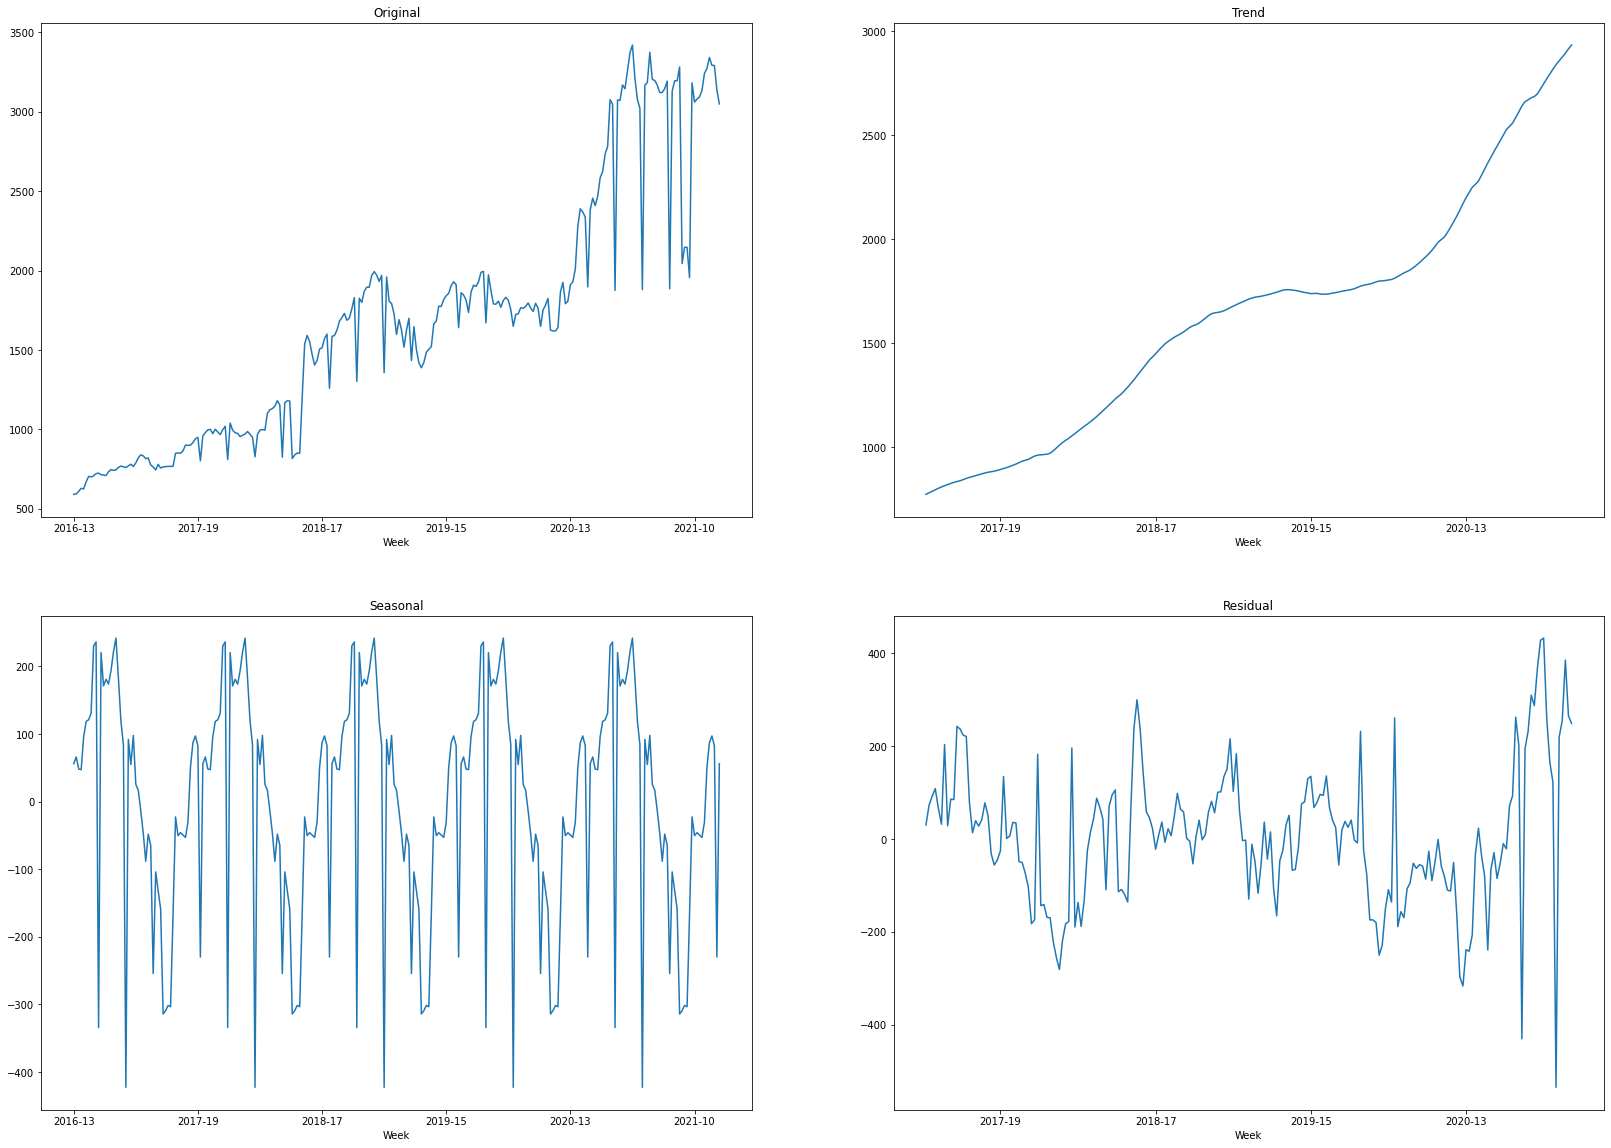

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(28, 20))
decompose = seasonal_decompose(dfw[['Avg']], period=52)

ax[0][0].set_title('Original')
ax[0][1].set_title('Trend')
ax[1][0].set_title('Seasonal')
ax[1][1].set_title('Residual')

decompose.observed.plot(ax=ax[0][0])
decompose.trend.plot(ax=ax[0][1])
decompose.seasonal.plot(ax=ax[1][0])
decompose.resid.plot(ax=ax[1][1]);

Как можно видеть, тренд и сезонность присутствуют.

In [10]:
adfuller(dfw['Avg'])[1]

0.93466207988557

Тест Дифи-Фуллера также показывает, что ряд не является стационарным.

Попробуем избавиться от тренда.

In [11]:
dfw.drop(['Open', 'Low', 'High', 'Close', 'Volume', 'Adj Close'], axis=1, inplace=True)
dfw.head()

,Avg
Week,
2016-13,591.119000
2016-14,593.419995
2016-15,610.170996
2016-16,628.709003
2016-17,625.207001


In [12]:
dfw['AvgDiff'] = dfw['Avg'] - dfw['Avg'].shift(1) # Тут вроде можно использовать df['Avg'].diff(), но это не точно
dfw.head()

,Avg,AvgDiff
Week,,
2016-13,591.119000,NaN
2016-14,593.419995,2.300995
2016-15,610.170996,16.751001
2016-16,628.709003,18.538007
2016-17,625.207001,-3.502002


In [13]:
def draw_original_and_diff(df: pd.DataFrame, original_name: str, diff_name: str):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))

    ax[0].set_title('Original')
    ax[0].set_ylabel(original_name, rotation=0, labelpad=30)
    dfw[original_name].plot(ax=ax[0]);

    ax[1].set_title('Diff')
    ax[1].set_ylabel(diff_name, rotation=0, labelpad=30)
    dfw[diff_name].plot(ax=ax[1])

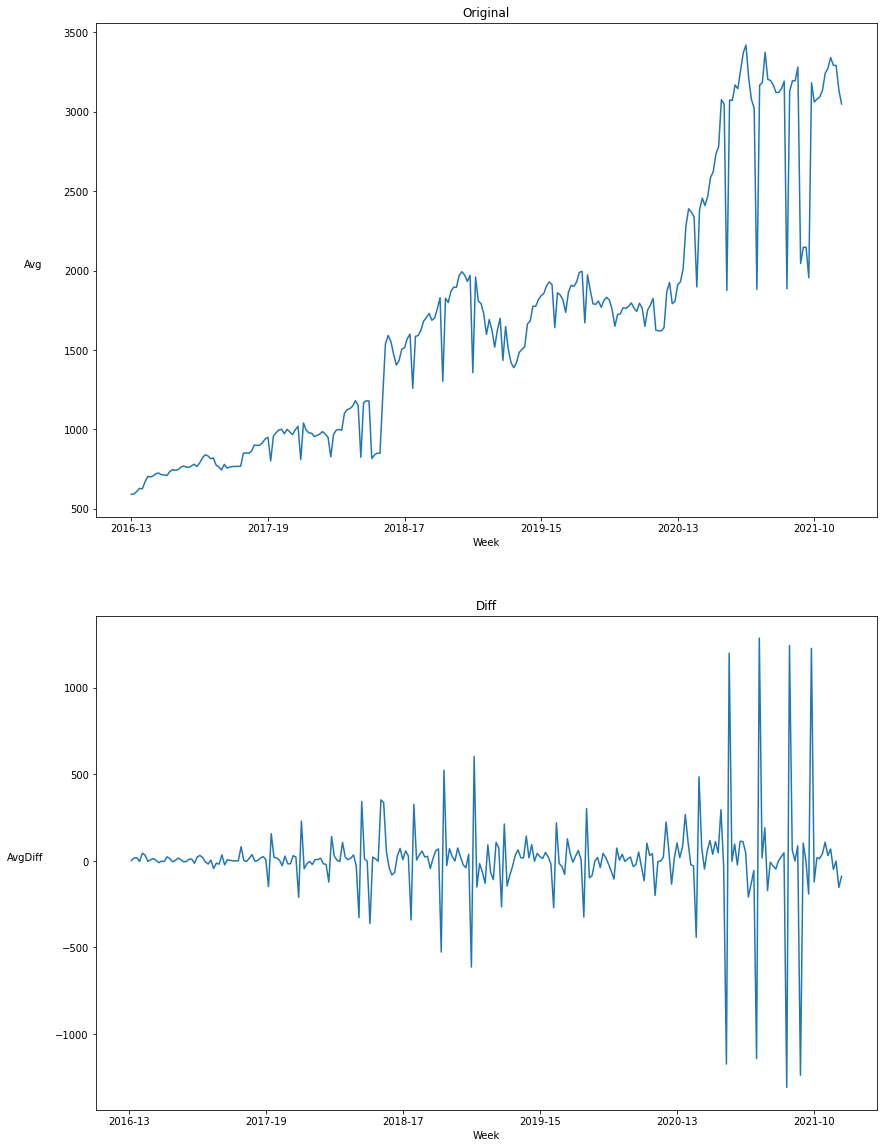

In [14]:
draw_original_and_diff(dfw, 'Avg', 'AvgDiff')

Как можно видеть, дисперсия вырастает около середины 2020 года, так что ряд не является стационарным. Пробуем дальше!

In [15]:
dfw['AvgLog'] = np.log(dfw['Avg'])
dfw['AvgLogDiff'] = dfw['AvgLog'] - dfw['AvgLog'].shift(1)
dfw.head()

,Avg,AvgDiff,AvgLog,AvgLogDiff
Week,,,,
2016-13,591.119000,NaN,6.382017,NaN
2016-14,593.419995,2.300995,6.385902,0.003885
2016-15,610.170996,16.751001,6.413739,0.027837
2016-16,628.709003,18.538007,6.443669,0.029929
2016-17,625.207001,-3.502002,6.438083,-0.005586


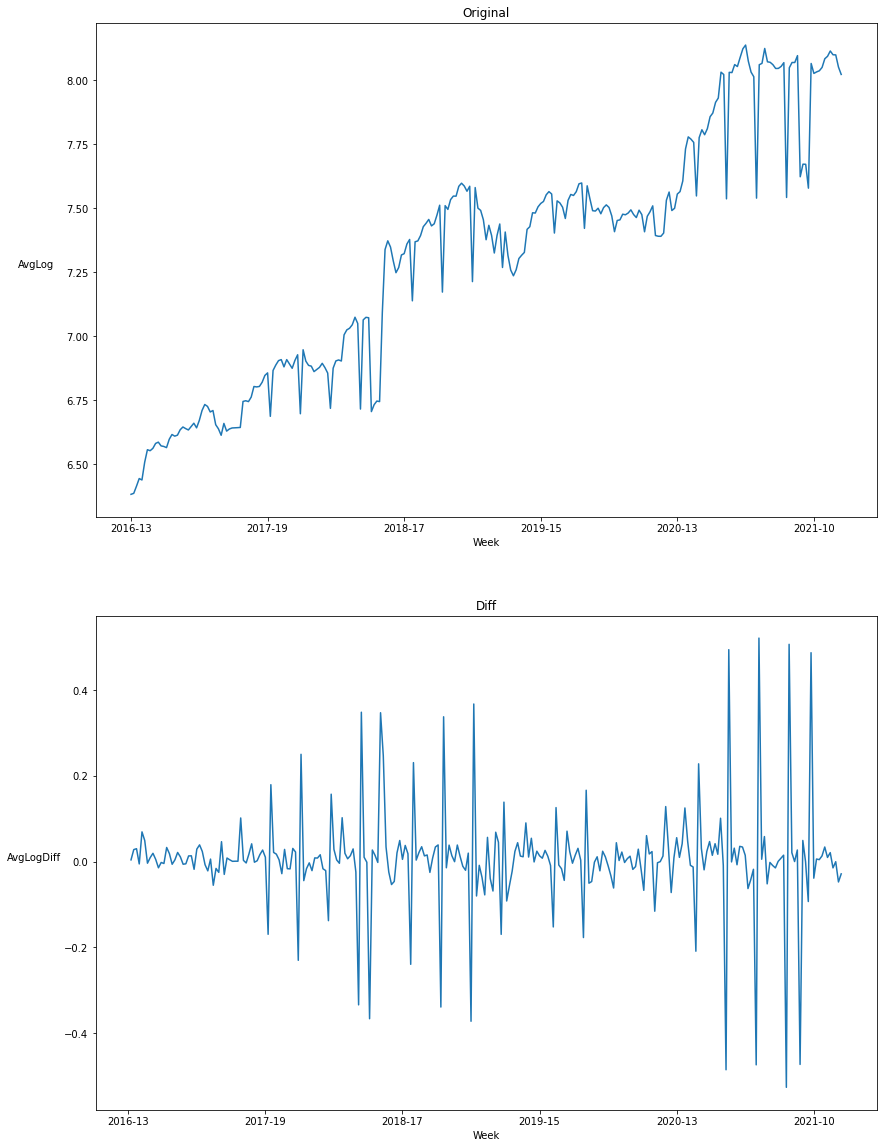

In [16]:
draw_original_and_diff(dfw, 'AvgLog', 'AvgLogDiff')

Опять мягко говоря не очень. Давайте заиспользуем Бокса-Кокса:

In [17]:
from scipy.stats import boxcox

dfw['AvgBoxCox'], lmbda = boxcox(dfw['Avg'])

print(lmbda)
dfw.head()

0.0752266256611616


,Avg,AvgDiff,AvgLog,AvgLogDiff,AvgBoxCox
Week,,,,,
2016-13,591.119000,NaN,6.382017,NaN,8.191677
2016-14,593.419995,2.300995,6.385902,0.003885,8.197957
2016-15,610.170996,16.751001,6.413739,0.027837,8.243008
2016-16,628.709003,18.538007,6.443669,0.029929,8.291551
2016-17,625.207001,-3.502002,6.438083,-0.005586,8.282483


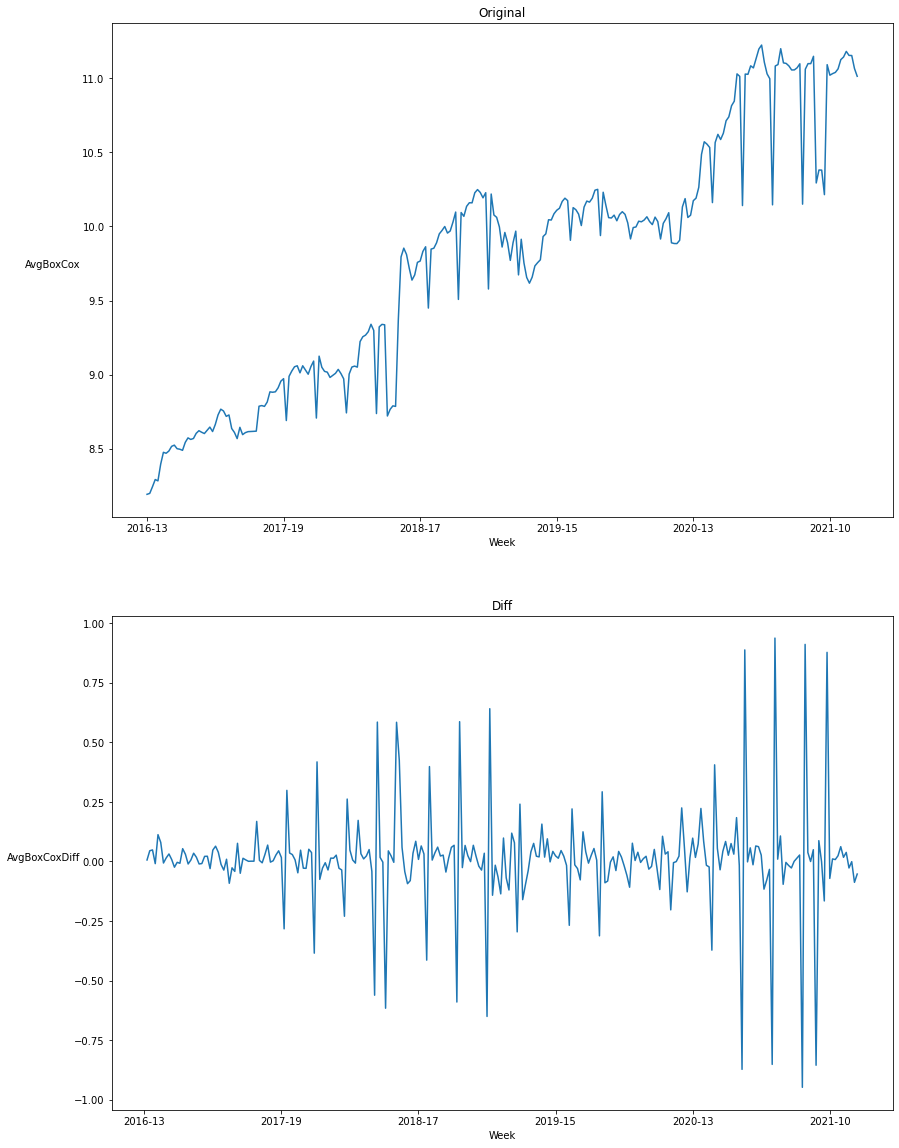

In [18]:
dfw['AvgBoxCoxDiff'] = dfw['AvgBoxCox'] - dfw['AvgBoxCox'].shift(1)

draw_original_and_diff(dfw, 'AvgBoxCox', 'AvgBoxCoxDiff')

In [19]:
adfuller(dfw['AvgBoxCoxDiff'][1:])[1]

4.125093339850687e-05

Получили довольно маленькое значение. Печалит то, что дисперсия всё ещё возрастает, но лучше уже не будет.

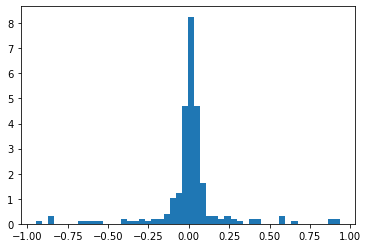

In [20]:
_, _, _ = plt.hist(dfw['AvgBoxCoxDiff'], density=True, bins=50)

<ipython-input-21-c7e76fb7d326>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


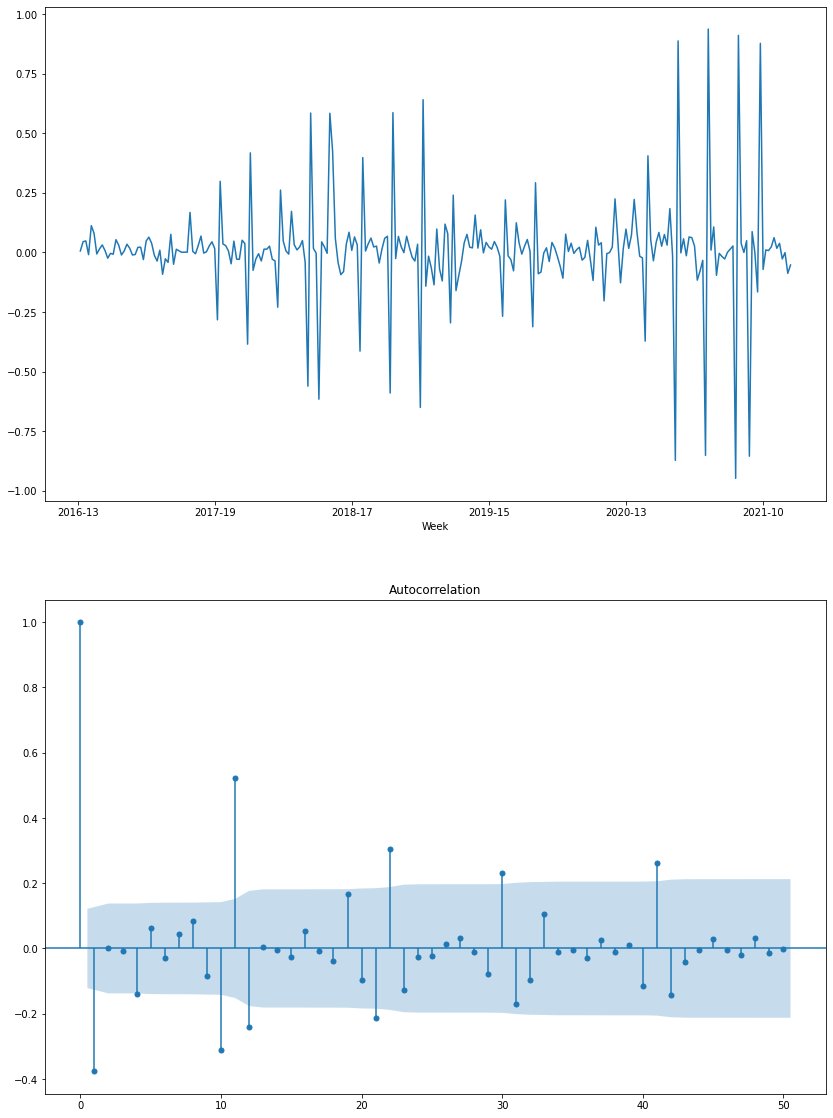

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))

dfw['AvgBoxCoxDiff'].plot(ax=ax[0])

plot_acf(dfw['AvgBoxCoxDiff'][1:], lags=50, ax=ax[1])

fig.show()

Значимых корелляций немного, и хотя их значимость существенна, лучше мы уже не сделаем =)

Обучим модель SARIMA с подбором параметров:

In [22]:
d=1
D=1

qs = range(1, 4)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 4)

from itertools import product
from tqdm import tqdm

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            dfw['AvgBoxCoxDiff'][:int(len(dfw['AvgBoxCoxDiff']) * 0.8)], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 6)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|          | 0/24 [00:00<?, ?it/s]/home/covariance/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/covariance/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
  4%|▍         | 1/24 [00:04<01:38,  4.28s/it]/home/covariance/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/covariance/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.

In [23]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       AvgBoxCoxDiff   No. Observations:                  208
Model:             SARIMAX(3, 1, 3)x(3, 1, [1], 6)   Log Likelihood                  85.577
Date:                             Wed, 17 Nov 2021   AIC                           -149.154
Time:                                     16:40:32   BIC                           -112.818
Sample:                                          0   HQIC                          -134.451
                                             - 208                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6130      0.047    -12.952      0.000      -0.706      -0.520
ar.L2         -1.0766      

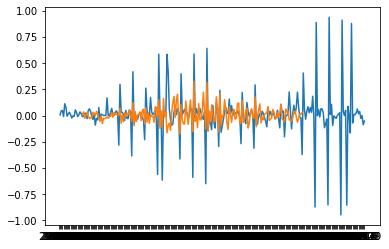

In [24]:
plt.plot(dfw.AvgBoxCoxDiff)
plt.plot(best_model.fittedvalues[20:])

In [30]:
real = dfw.AvgBoxCoxDiff[20:208].values
pred = best_model.fittedvalues[20:]

((real - pred) ** 2).sum() / len(pred)

0.022587615287401046